# Structural Analysis of the Interface

description... Gliederung??

## Import Statements

In [305]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import os
from pymol import cmd
from collections import defaultdict, Counter 
from sklearn.preprocessing import MinMaxScaler
from Bio.SeqUtils import seq1
from Bio import SeqIO # to read sequences from a FASTA file
from Bio import pairwise2 # pairwise sequence alignments
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import matplotlib.cm as cm
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import mannwhitneyu



plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['axes.titleweight'] = 'bold'


## Data Preparation

### Download and Save PDB files for each checkpoint

In [306]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]

In [307]:
# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]

In [308]:
combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

In [309]:
shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

### Extract and Clean Antibody-Checkpoint Associations

In [310]:
l = ['CTLA-4', 'TIM3', 'PD-1', 'PD-L1', 'KIR', 'LAG3']

cp_cout_df = pd.DataFrame(index = l)

for item in l:
    count = shuffled_df[shuffled_df['compound'].str.contains(item, na=False)].shape[0]
    cp_cout_df.loc[item, 'count'] = count

cp_cout_df = cp_cout_df.reset_index()
cp_cout_df.columns = ['checkpoint', 'count'] 

In [311]:
# 1. Filter all relevant rows: those with 'mab' OR 'M6903'
ab_mask = shuffled_df['compound'].str.contains('mab|M6903', na=False, case=False)
shuffled_df_ab = shuffled_df[ab_mask]

# 2. Extract antibody names
shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)

# 3. Fill in M6903 manually where missing
m6903_mask = shuffled_df_ab['compound'].str.contains('M6903', na=False)
shuffled_df_ab.loc[m6903_mask, 'antibody'] = shuffled_df_ab.loc[m6903_mask, 'antibody'].fillna('M6903')

# # 4. Extract checkpoint names
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)

# # 5. Final formatting
shuffled_df_ab = shuffled_df_ab[['antibody', 'checkpoint', 'pdb', 'Hchain', 'Lchain', 'antigen_chain']]
shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

shuffled_df_ab

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/60524799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)
/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/60524799.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)


,antibody,checkpoint,pdb,Hchain,Lchain,antigen_chain
0,PEMBROLIZUMAB,PD-1,5b8c,E,D,F
1,IPILIMUMAB,CTLA-4,5xj3,D,E,F
2,PEMBROLIZUMAB,PD-1,5jxe,G,F,A
4,CEMIPLIMAB,PD-1,8gy5,H,L,P
5,ATEZOLIZUMAB,PD-L1,5x8l,J,O,E
11,PEMBROLIZUMAB,PD-1,5b8c,B,A,C
12,IPILIMUMAB,CTLA-4,5xj3,A,B,C
14,IPILIMUMAB,CTLA-4,7su0,I,M,D
15,TREMELIMUMAB,CTLA-4,5ggv,H,L,Y
16,NIVOLUMAB,PD-1,5ggr,H,L,Z


In [312]:
pdb_list = shuffled_df_ab['pdb'].unique().tolist()
#shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

# with open('pdb_list.txt', 'w') as f:
#     for pdb in pdb_list:
#         f.write(pdb + '\n')

In [313]:
# make a list of the columns 
shuffled_df_ab = shuffled_df_ab[['pdb', 'Hchain', 'Lchain', 'antigen_chain']]
extracted_list = shuffled_df_ab.values.tolist()

extracted_list


[['5b8c', 'E', 'D', 'F'],
 ['5xj3', 'D', 'E', 'F'],
 ['5jxe', 'G', 'F', 'A'],
 ['8gy5', 'H', 'L', 'P'],
 ['5x8l', 'J', 'O', 'E'],
 ['5b8c', 'B', 'A', 'C'],
 ['5xj3', 'A', 'B', 'C'],
 ['7su0', 'I', 'M', 'D'],
 ['5ggv', 'H', 'L', 'Y'],
 ['5ggr', 'H', 'L', 'Z'],
 ['5x8l', 'G', 'L', 'B'],
 ['7bxa', 'H', 'L', 'P'],
 ['5xxy', 'H', 'L', 'A'],
 ['9dq4', 'H', 'L', 'A'],
 ['5ggr', 'A', 'B', 'Y'],
 ['5ggs', 'C', 'D', 'Y'],
 ['5xj3', 'G', 'H', 'I'],
 ['8tui', 'H', 'L', 'A'],
 ['5x8m', 'B', 'C', 'A'],
 ['7wvm', 'A', 'B', 'E'],
 ['6txz', 'K', 'O', 'D'],
 ['5grj', 'H', 'L', 'A'],
 ['8gy5', 'A', 'B', 'Q'],
 ['5ggs', 'A', 'B', 'Z'],
 ['5jxe', 'D', 'C', 'B'],
 ['7cu5', 'B', 'B', 'E'],
 ['6k0y', 'A', 'B', 'C'],
 ['6txz', 'I', 'M', 'B'],
 ['7cgw', 'H', 'L', 'P'],
 ['6txz', 'H', 'L', 'A'],
 ['5xj4', 'H', 'L', 'A'],
 ['9dq3', 'H', 'L', 'C'],
 ['5x8l', 'F', 'K', 'A'],
 ['7su0', 'H', 'L', 'C'],
 ['5wt9', 'H', 'L', 'G'],
 ['5x8l', 'S', 'N', 'D'],
 ['5b8c', 'H', 'G', 'I'],
 ['7bxa', 'B', 'C', 'A'],
 ['7cgw', 'A

## Structural Feature Analysis 

### Surface Area, Hydrogen-Bonds and Saltbridges Extraction

In [314]:
results = []
section = 'epitope' 

root_folder = "structures"
cutoff_distance = 5.0  # in Å distance
hbond_cutoff = 3.5  # in Å distance for hydrogen bonds
salt_cutoff = 4.0  # in Å distance for salt bridges

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data if available

# Extracted list: [pdb_id, H_chain, L_chain, antigen_chain]

# Loop over each chain combination from the extracted list
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

        cmd.reinitialize()
        cmd.bg_color("white")
        cmd.load(pdb_path)

        # Selections
        cmd.select("antibody", f"chain {h_chain}+{l_chain}")
        cmd.select("antigen", f"chain {ag_chain}")
        if section == 'paratope':
            cmd.select(f"{section}", f"antibody within {cutoff_distance} of antigen")
        else:
            cmd.select(f"{section}", f"antigen within {cutoff_distance} of antibody")
        # Color antibody chains 
        cmd.color("marine", f"chain {h_chain}")
        cmd.color("skyblue", f"chain {l_chain}")

        # Color antigen chain 
        cmd.color("salmon", "antigen")

        # Highlight paratope/epitope
        cmd.color("yellow", f"{section}")

        # Surface area
        paratope_area = cmd.get_area(f"{section}")
        print(f" Epitope surface area: {paratope_area:.2f} Å²")

        # Hydrogen bonds
        hbonds = cmd.find_pairs("antibody", "antigen", mode=1, cutoff=hbond_cutoff)
        num_hbonds = len(hbonds)
        print(f"Found {num_hbonds} hydrogen bonds at the interface.")

        # salt bridges 
        # antibody acidic O  → antigen basic N
        cmd.select("acidic_ab", f"chain {h_chain}+{l_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ag",  f"chain {ag_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb1 = cmd.find_pairs("acidic_ab", "basic_ag", cutoff=salt_cutoff, mode=1)

        # antigen acidic O → antibody basic N
        cmd.select("acidic_ag", f"chain {ag_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ab",  f"chain {h_chain}+{l_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb2 = cmd.find_pairs("acidic_ag", "basic_ab", cutoff=salt_cutoff, mode=1)

        # cleanup salt-bridge selections
        for sel in ("acidic_ab","basic_ag","acidic_ag","basic_ab"):
            cmd.delete(sel)

        num_salt_bridges = len(sb1) + len(sb2)
        print(f"   ➤ Salt bridges: {num_salt_bridges}")

        # save session 
        session_out = os.path.join(dirpath, f"{pdb_id}_{section}.pse")
        cmd.save(session_out)

        # collect results 
        results.append({
            "pdb_id":              pdb_id,
            "H_chain":             h_chain,
            "L_chain":             l_chain,
            "antigen_chain":       ag_chain,
            f"{section}_area":       paratope_area,
            "num_hydrogen_bonds":  num_hbonds,
            "num_salt_bridges":    num_salt_bridges,
            "folder":              os.path.basename(dirpath)
        })

# Save to CSV
df_struc_info = pd.DataFrame(results)

# Save results to CSV 
df_struc_info = pd.DataFrame(results)
df_struc_info.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_surface_hbonds_salt_bridges_summary.csv", index=False)

#print(f"Results saved to '{section}_surface_hbonds_salt_bridges_summary.csv'")

Processing 5b8c...
 Epitope surface area: 1769.81 Å²
Found 27 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5xj3...
 Epitope surface area: 1529.39 Å²
Found 20 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5jxe...
 Epitope surface area: 1245.53 Å²
Found 19 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 8gy5...
 Epitope surface area: 1210.95 Å²
Found 19 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 5x8l...
 Epitope surface area: 1705.83 Å²
Found 29 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5b8c...
 Epitope surface area: 1872.03 Å²
Found 32 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5xj3...
 Epitope surface area: 1485.81 Å²
Found 16 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 7su0...
 Epitope surface area: 1668.17 Å²
Found 16 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 5ggv...
 Epitope surface area: 2085.56 Å²
Found 40 hydrogen b

In [315]:
#df_struc_info = pd.read_csv(f"{section}_surface_hbonds_salt_bridges_summary.csv")
# print(df_struc_info['pdb_id'].value_counts())

### Visualizing Structural Features

#### barplot - surface area 

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

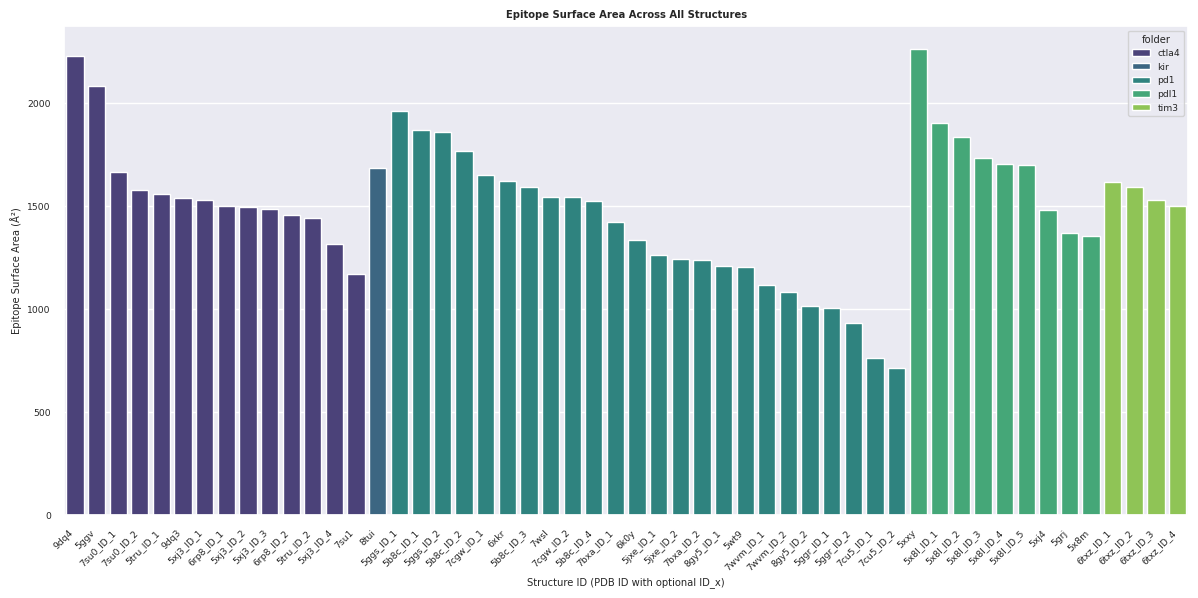

In [316]:

# Sort as before
df_sorted = df_struc_info.sort_values(by=["folder", f"{section}_area"], ascending=[True, False]).copy()


# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y=f"{section}_area", hue="folder", dodge=False, palette="viridis")


plt.title(f"{section.capitalize()} Surface Area Across All Structures")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel(f"{section.capitalize()} Surface Area (Å²)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_surface_area_across_all_structures.pdf', bbox_inches='tight')
plt.show()



#### Scatter Plot - Hydrogen Bonds vs Surface Area

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

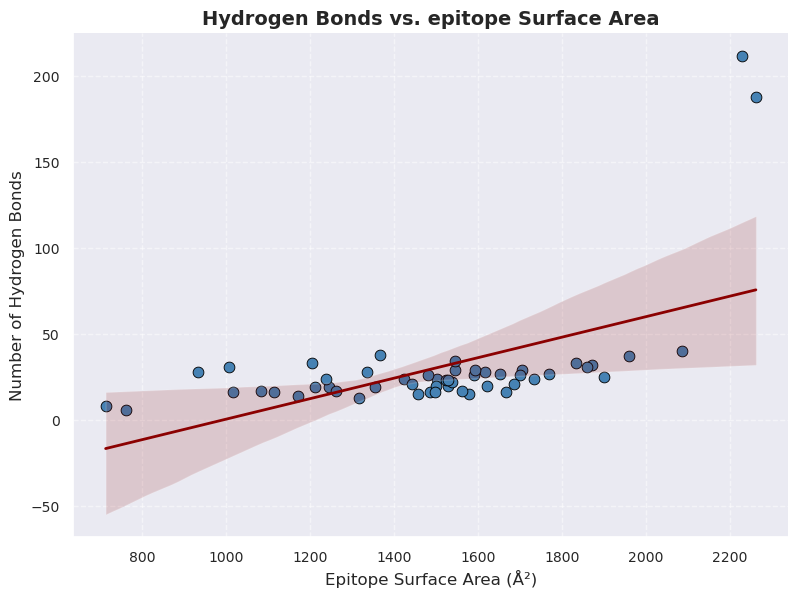

In [317]:
df_struc_info = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_surface_hbonds_salt_bridges_summary.csv")

plt.figure(figsize=(8, 6))

# Scatterplot
sns.scatterplot(
    data=df_struc_info,
    x=f"{section}_area",
    y="num_hydrogen_bonds",
    s=60,
    color="steelblue",
    edgecolor="black"
)

# Regression line
sns.regplot(
    data=df_struc_info,
    x=f"{section}_area",
    y="num_hydrogen_bonds",
    scatter=False,
    color="darkred",
    line_kws={'linewidth': 2}
)

# Styling
plt.title(f"Hydrogen Bonds vs. {section} Surface Area", fontsize=14, fontweight="bold")
plt.xlabel(f"{section.capitalize()} Surface Area (Å²)", fontsize=12)
plt.ylabel("Number of Hydrogen Bonds", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()

# Save (optional)
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/hbonds_vs_surface_area_{section}.pdf", bbox_inches='tight')
plt.show()


#### Barplot - Hydrogen Bonds per PDB ID

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

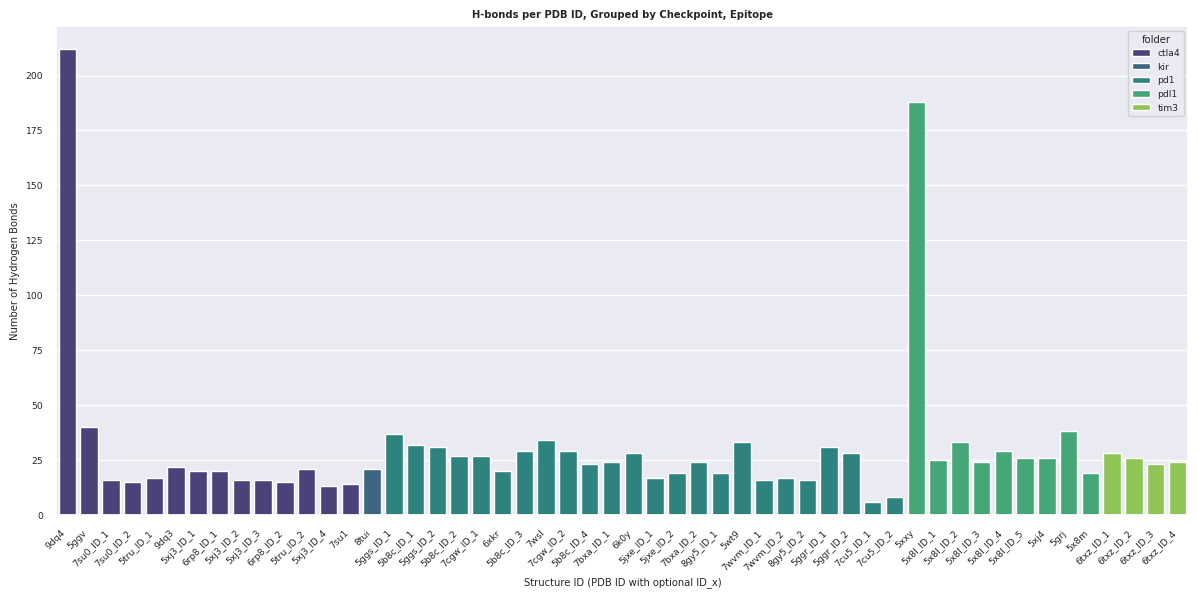

In [318]:
df_sorted_h = df_struc_info.sort_values(by=["folder", "num_hydrogen_bonds"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_h["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_h["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_h["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="num_hydrogen_bonds", hue="folder", dodge=False, palette="viridis")

plt.title(f"H-bonds per PDB ID, Grouped by Checkpoint, {section.capitalize()}")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Hydrogen Bonds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_h_bonds_per_PDB.pdf', bbox_inches='tight')
plt.show()

#### Barplot - Salt Bridges per PDB ID

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

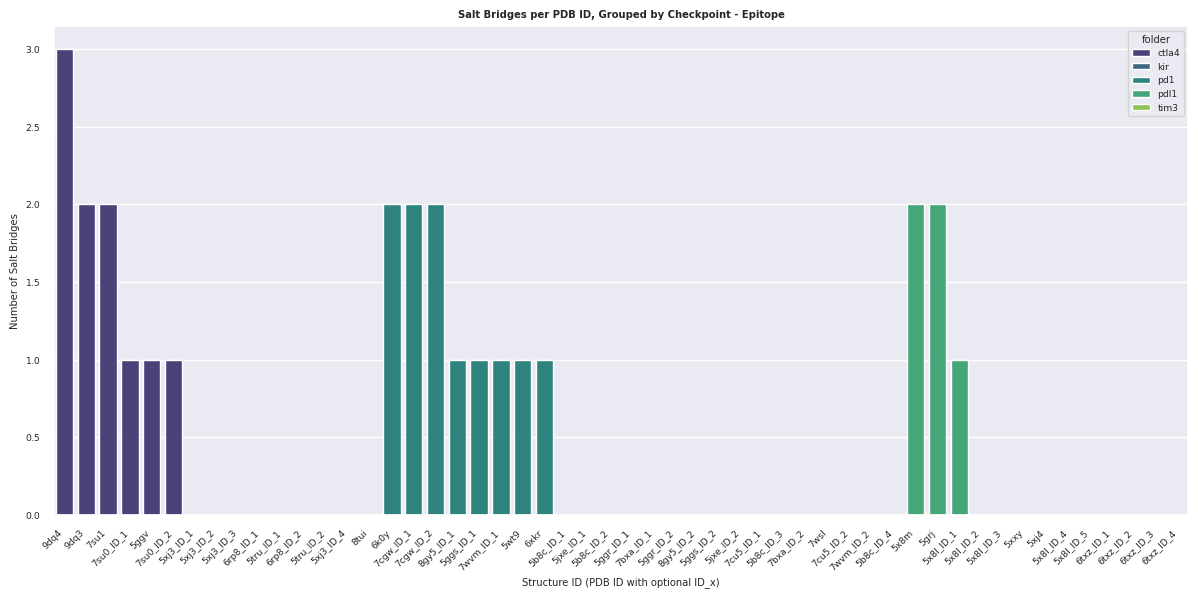

In [319]:

df_sorted_s = df_struc_info.sort_values(by=["folder", "num_salt_bridges"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_s["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_s["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_s["structure_id"] = structure_ids


# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted_s, x="structure_id", y="num_salt_bridges", hue="folder", dodge=False, palette="viridis")

plt.title(f"Salt Bridges per PDB ID, Grouped by Checkpoint - {section.capitalize()}")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Salt Bridges")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_salt_bridges_per_PDB.pdf', bbox_inches='tight')
plt.show() 



## Binding Score 

In [320]:

#normalizing with MinMax
scaler = MinMaxScaler()
df = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_surface_hbonds_salt_bridges_summary.csv")
features = df[["num_hydrogen_bonds", "num_salt_bridges", f"{section}_area"]]
normalized = scaler.fit_transform(features)

df_norm = pd.DataFrame(normalized, columns=features.columns)
df_norm["pdb_id"] = df["pdb_id"]  

# Create a binding strength score
weights = {
    "num_hydrogen_bonds": 0.4,
    "num_salt_bridges": 0.4,
    f"{section}_area": 0.2
}

df_norm["binding_score"] = (
    df_norm["num_hydrogen_bonds"] * weights["num_hydrogen_bonds"] +
    df_norm["num_salt_bridges"] * weights["num_salt_bridges"] +
    df_norm[f"{section}_area"] * weights[f"{section}_area"]
)

In [321]:
# Sort the dataframe
df_sorted_bs = df_norm.sort_values(
    by=["binding_score", "num_hydrogen_bonds", "num_salt_bridges", f"{section}_area"],
    ascending=[False, False, False, False]  
).copy()
# Count appearances
id_frequencies = Counter(df_sorted_bs["pdb_id"])
id_tracker = defaultdict(int)

# Build unique structure IDs
structure_ids = []
for pdb_id in df_sorted_bs["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

# Add to DataFrame
df_sorted_bs["structure_id"] = structure_ids

### barplot - Binding Score Composition per PDB ID

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/3085022439.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font fa

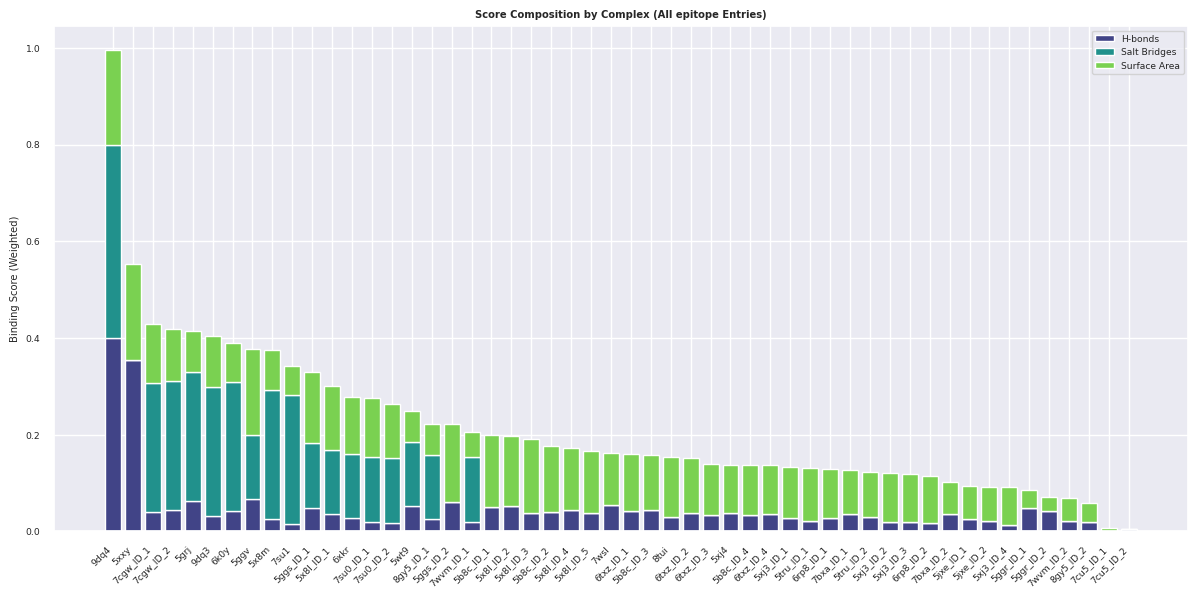

In [322]:
# Sort by binding score again
top = df_sorted_bs.sort_values("binding_score", ascending=False)

# Use viridis colormap
viridis = cm.get_cmap("viridis")
colors = viridis(np.linspace(0.2, 0.8, 3))

plt.figure(figsize=(12, 6))

# Plot H-bonds
plt.bar(
    top["structure_id"],
    top["num_hydrogen_bonds"] * 0.4,
    label="H-bonds",
    color=colors[0],
    bottom=0
)

# Plot Salt Bridges
plt.bar(
    top["structure_id"],
    top["num_salt_bridges"] * 0.4,
    label="Salt Bridges",
    color=colors[1],
    bottom=top["num_hydrogen_bonds"] * 0.4
)

# Plot Surface Area
plt.bar(
    top["structure_id"],
    top[f"{section}_area"] * 0.2,
    label="Surface Area",
    color=colors[2],
    bottom=(top["num_hydrogen_bonds"] + top["num_salt_bridges"]) * 0.4
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Binding Score (Weighted)")
plt.title(f"Score Composition by Complex (All {section} Entries)")
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_binding_affinity_score.pdf", bbox_inches="tight")
plt.show()




## Sequence Analysis

### Sequences Extraction

In [323]:
# not unqiue sequences
# Input settings
root_folder = "structures"
cutoff_distance = 5.0 
section = 'epitope' 
results = []

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data

# Loop through all extracted entries
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

    cmd.reinitialize()
    cmd.load(pdb_path)

    # Define selections
    cmd.select("antibody", f"chain {h_chain}+{l_chain}")
    cmd.select("antigen", f"chain {ag_chain}")
    if section == 'paratope':
        cmd.select(f"{section}", f"antibody within {cutoff_distance} of antigen")
    else:
        cmd.select(f"{section}", f"antigen within {cutoff_distance} of antibody")

    # Extract unique residues from epitope
    model = cmd.get_model(f"{section}")
    seen = set()
    residues = []
    for atom in model.atom:
        res_id = (atom.chain, atom.resi)
        if res_id not in seen:
            seen.add(res_id)
            residues.append(atom.resn)

    sequence = ''.join(seq1(res) for res in residues if res != "HOH")

    # Collect results
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        f"{section}_sequence": sequence,
        "folder": os.path.basename(dirpath)
    })

# Convert to DataFrame
df_seq = pd.DataFrame(results)

# Assign unique structure_id 
df_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()
id_frequencies = Counter(df_seq["pdb_id"])
id_tracker = defaultdict(int)

structure_ids = []
for pdb_id in df_seq["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_seq["structure_id"] = structure_ids

# Save CSV
df_seq.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_sequences_summary.csv", index=False)
#print(f"Summary table saved to '{section}_sequences_summary.csv'")

# Save FASTA
with open(f"data/structural_analysis/{section.capitalize()}/{section}_sequences.fasta", "w") as f:
    for _, row in df_seq.iterrows():
        f.write(f">{row['structure_id']}\n{row[f'{section}_sequence']}\n")

print(f"FASTA file saved to '{section}_sequences.fasta'")

# Add sequence to df_sorted

df_sorted_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()
   

Processing 5b8c...
Processing 5xj3...
Processing 5jxe...
Processing 8gy5...
Processing 5x8l...
Processing 5b8c...
Processing 5xj3...
Processing 7su0...
Processing 5ggv...
Processing 5ggr...
Processing 5x8l...
Processing 7bxa...
Processing 5xxy...
Processing 9dq4...
Processing 5ggr...
Processing 5ggs...
Processing 5xj3...
Processing 8tui...
Processing 5x8m...
Processing 7wvm...
Processing 6txz...
Processing 5grj...
Processing 8gy5...
Processing 5ggs...
Processing 5jxe...
Processing 7cu5...
Processing 6k0y...
Processing 6txz...
Processing 7cgw...
Processing 6txz...
Processing 5xj4...
Processing 9dq3...
Processing 5x8l...
Processing 7su0...
Processing 5wt9...
Processing 5x8l...
Processing 5b8c...
Processing 7bxa...
Processing 7cgw...
Processing 7wsl...
Processing 7cu5...
Processing 6txz...
Processing 6rp8...
Processing 5x8l...
Processing 6xkr...
Processing 7wvm...
Processing 5tru...
Processing 7su1...
Processing 5b8c...
Processing 6rp8...
Processing 5tru...
Processing 5xj3...
FASTA file s

### Identiy Matrix

In [324]:
# Load sequences
records = list(SeqIO.parse(f"data/structural_analysis/{section.capitalize()}/{section}_sequences.fasta", "fasta"))

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq) # Align two sequences (whole sequence)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100  # identiy in % -> (number of matches) / (length of longer sequence) × 100
        row.append(round(identity, 2))
    matrix.append(row)

# Create a DataFrame
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# Save & show
df_identity.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_sequence_comparison_matrix.csv")
print(f" Sequence identity matrix saved to '{section}_sequence_comparison_matrix.csv'")
print(df_identity)


 Sequence identity matrix saved to 'epitope_sequence_comparison_matrix.csv'
           6rp8_ID_1    9dq3  6rp8_ID_2  5xj3_ID_1  5xj3_ID_2  5xj3_ID_3  \
6rp8_ID_1     100.00   84.62      88.46      76.92      84.62      88.46   
9dq3           84.62  100.00      91.30      78.26      79.17      80.00   
6rp8_ID_2      88.46   91.30     100.00      82.61      87.50      84.00   
5xj3_ID_1      76.92   78.26      82.61     100.00      91.67      88.00   
5xj3_ID_2      84.62   79.17      87.50      91.67     100.00      96.00   
5xj3_ID_3      88.46   80.00      84.00      88.00      96.00     100.00   
5ggv           70.97   70.97      67.74      64.52      70.97      74.19   
5xj3_ID_4      80.77   79.17      83.33      91.67      95.83      92.00   
9dq4           56.25   53.12      50.00      50.00      50.00      53.12   
7su0_ID_1      96.15   84.62      84.62      76.92      80.77      84.62   
7su0_ID_2      89.29   78.57      82.14      75.00      82.14      85.71   
5tru_ID_1   

In [325]:
# Load sequences
records = list(SeqIO.parse(f"data/structural_analysis/{section.capitalize()}/{section}_sequences.fasta", "fasta"))

# Define PDB IDs to exclude 
if section.lower() == "paratope":
    excluded_ids = {"7cu5_ID_2", "5x8l_ID_2", "6txz_ID_2", "6txz_ID_3"}
else: 
    excluded_ids = {"5ggr_ID_2", "5b8c_ID_4", "5x8l_ID_4"}

# Filter records
records = [rec for rec in records if rec.id not in excluded_ids]

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100
        row.append(round(identity, 2))
    matrix.append(row)

# DF
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# Save 
df_identity.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_sequence_comparison_matrix.csv")
print(f"Sequence identity matrix saved to '{section}_sequence_comparison_matrix.csv'")
print(df_identity)


Sequence identity matrix saved to 'epitope_sequence_comparison_matrix.csv'
           6rp8_ID_1    9dq3  6rp8_ID_2  5xj3_ID_1  5xj3_ID_2  5xj3_ID_3  \
6rp8_ID_1     100.00   84.62      88.46      76.92      84.62      88.46   
9dq3           84.62  100.00      91.30      78.26      79.17      80.00   
6rp8_ID_2      88.46   91.30     100.00      82.61      87.50      84.00   
5xj3_ID_1      76.92   78.26      82.61     100.00      91.67      88.00   
5xj3_ID_2      84.62   79.17      87.50      91.67     100.00      96.00   
5xj3_ID_3      88.46   80.00      84.00      88.00      96.00     100.00   
5ggv           70.97   70.97      67.74      64.52      70.97      74.19   
5xj3_ID_4      80.77   79.17      83.33      91.67      95.83      92.00   
9dq4           56.25   53.12      50.00      50.00      50.00      53.12   
7su0_ID_1      96.15   84.62      84.62      76.92      80.77      84.62   
7su0_ID_2      89.29   78.57      82.14      75.00      82.14      85.71   
5tru_ID_1    

### Heatmap - Sequence Identity 

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/362802179.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{x:.0f}")


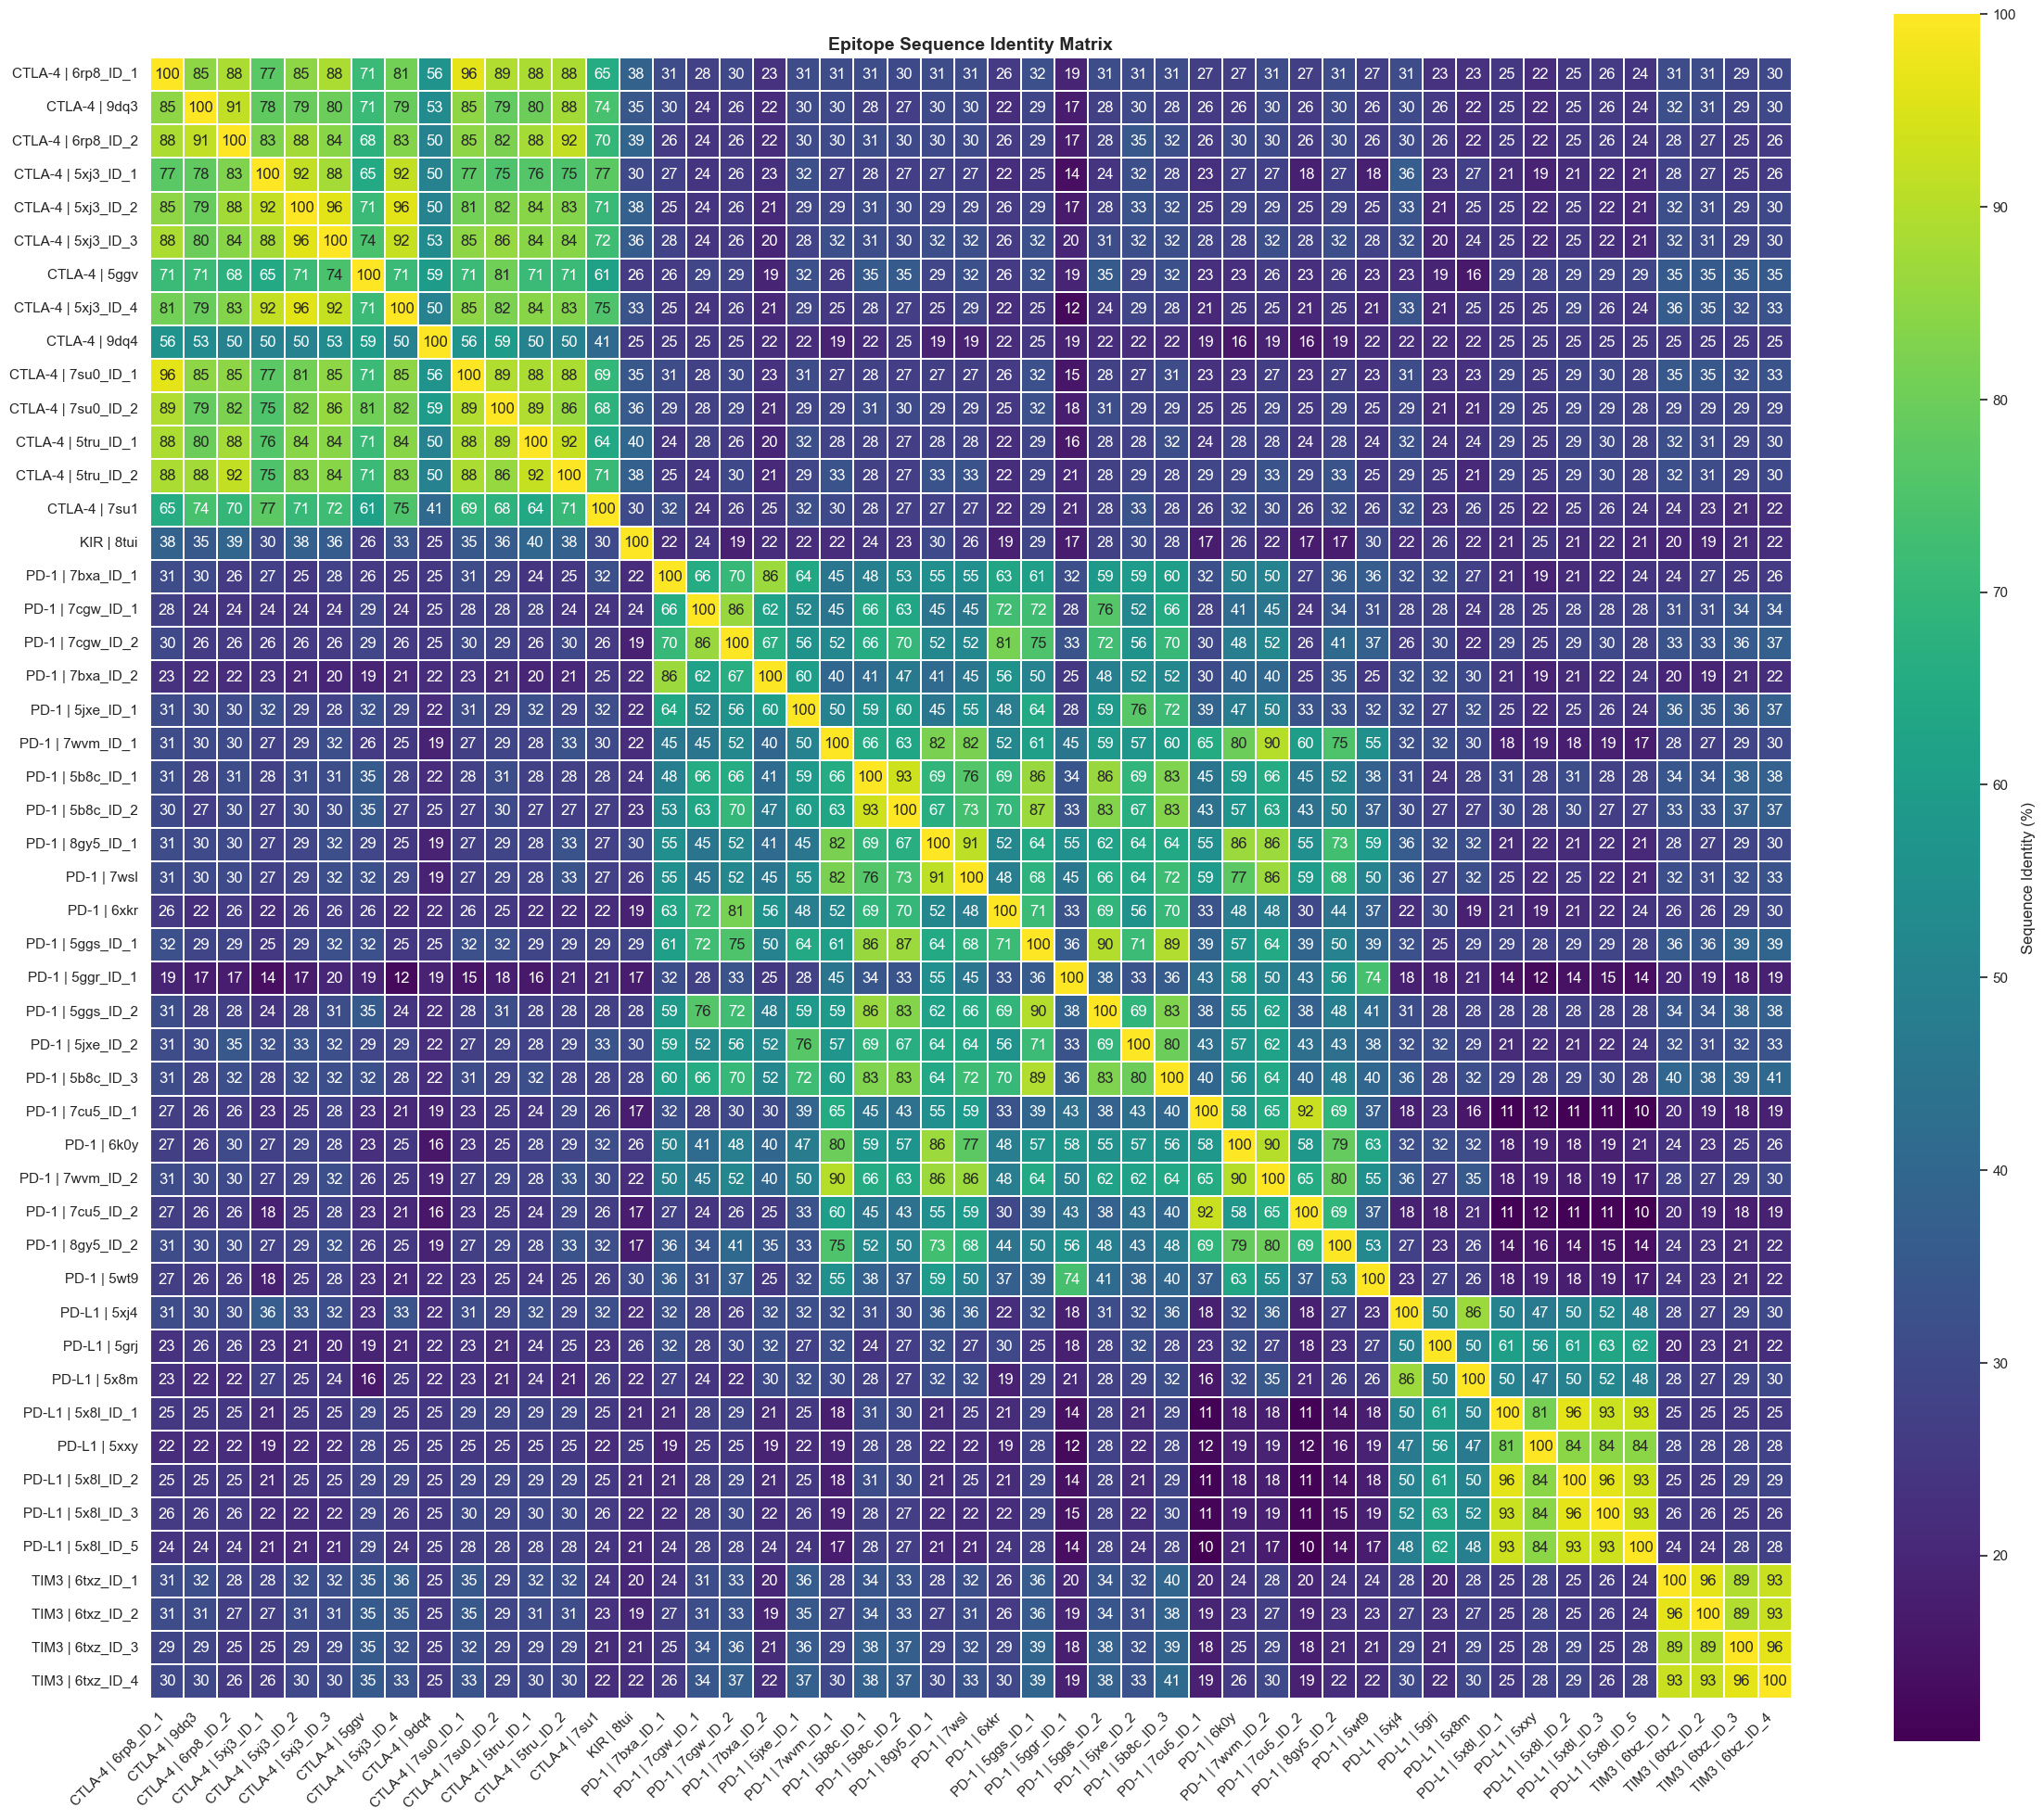

Cleaned-up heatmap saved as 'epitope_identity_heatmap_final.pdf'


In [326]:
checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), 
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Create mapping from PDB ID → Checkpoint
pdb_to_checkpoint = {}
for checkpoint, pdb_list in pdb_ids.items():
    for pdb in pdb_list:
        pdb_to_checkpoint[pdb.lower()] = checkpoint

# Update row and column labels using base PDB ID
def get_checkpoint_label(pdb_id):
    '''Get checkpoint label for a given PDB ID'''
    base_id = pdb_id.lower().split('_')[0]
    checkpoint = pdb_to_checkpoint.get(base_id)  
    return f"{checkpoint} | {pdb_id}"

df_identity = df_identity.copy()
df_identity.index = [get_checkpoint_label(p) for p in df_identity.index]
df_identity.columns = [get_checkpoint_label(p) for p in df_identity.columns]



annot_data = df_identity.applymap(lambda x: f"{x:.0f}")
mask = None

plt.figure(figsize=(24, 20))
sns.set(style="white", font_scale=1.0)

ax = sns.heatmap(
    df_identity, 
    annot=annot_data, 
    fmt="", 
    cmap="viridis", 
    mask=mask,
    square=True, 
    linewidths=0.3, 
    cbar_kws={"label": "Sequence Identity (%)"}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title(f"{section.capitalize()} Sequence Identity Matrix", fontsize=14)
plt.tight_layout()

plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_identity_heatmap_final.pdf", dpi=300)
plt.show()

print(f"Cleaned-up heatmap saved as '{section}_identity_heatmap_final.pdf'")

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/295800801.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


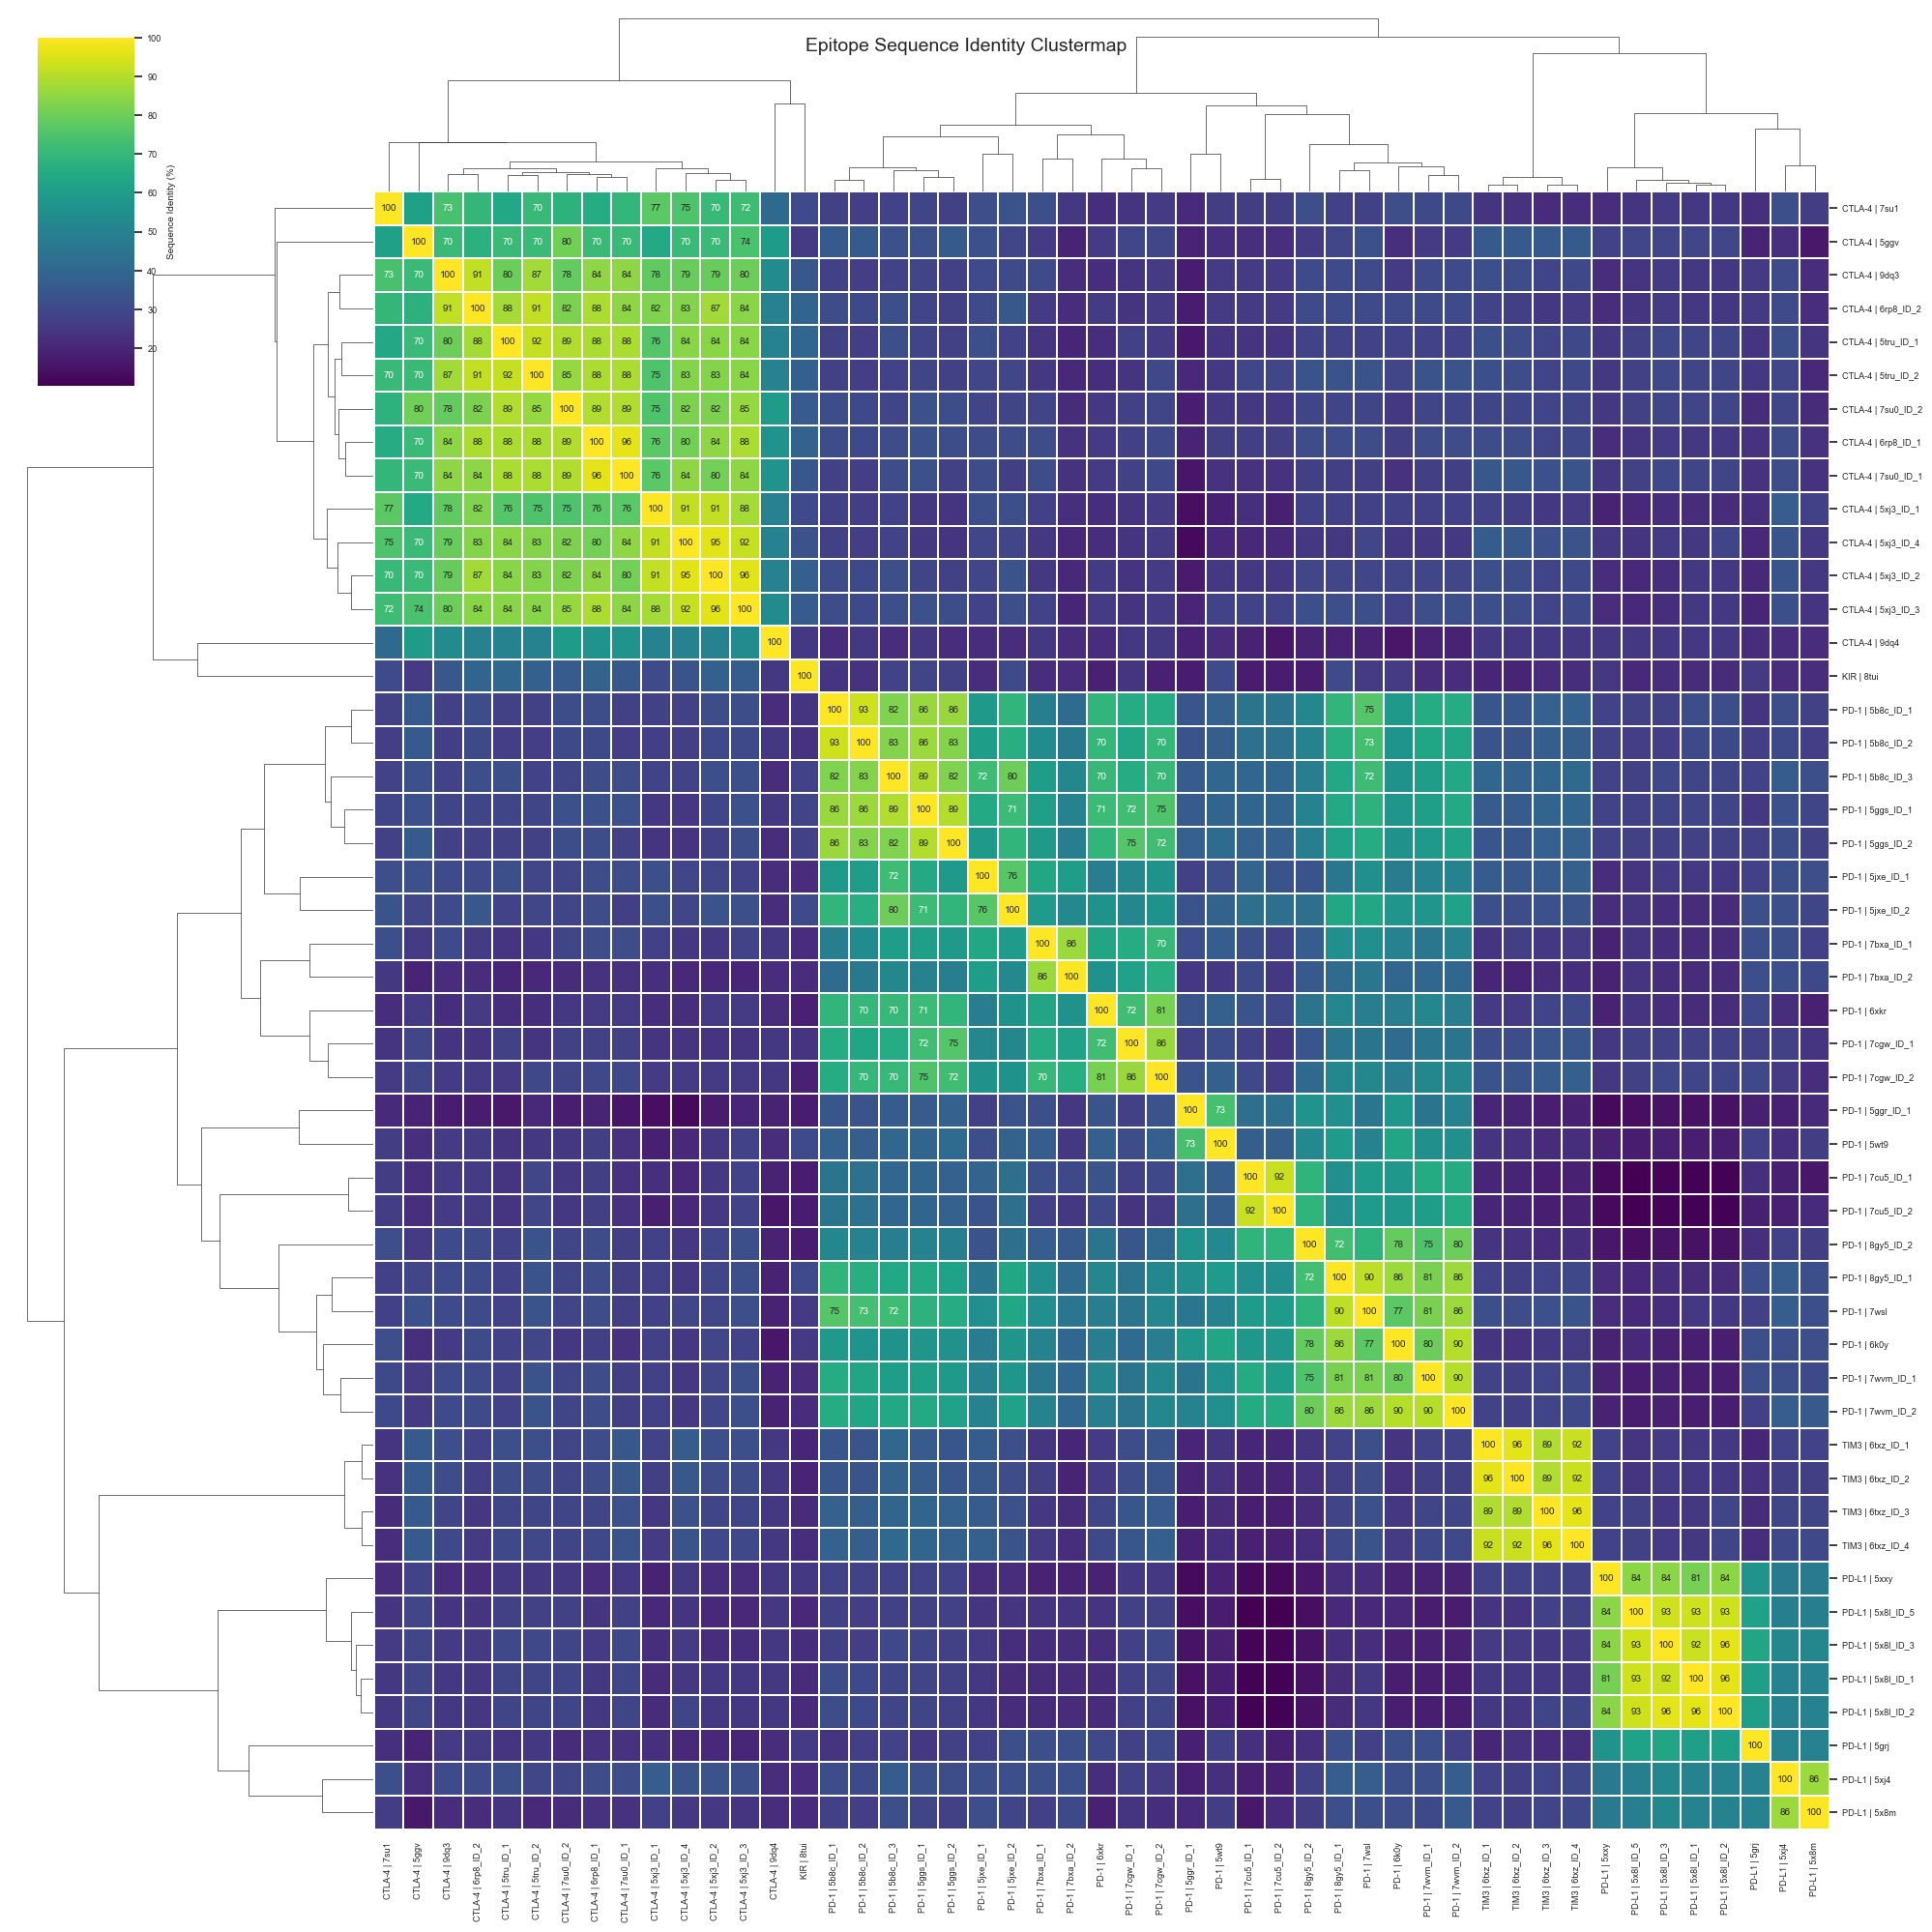

In [327]:
# annotate only high identities
annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")

# clustermap
sns.set(font_scale=0.6)  
g = sns.clustermap(
    df_identity,
    cmap="viridis",
    figsize=(20, 20),
    annot=annot_data,
    fmt="",
    linewidths=0.3,
    cbar_kws={"label": "Sequence Identity (%)"},
    dendrogram_ratio=(.2, .1),  # ratio for row/col dendrograms
    xticklabels=True,
    yticklabels=True
)

#save 
g.fig.suptitle(f"{section.capitalize()} Sequence Identity Clustermap", fontsize=14)
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_clustermap.pdf", dpi=300, bbox_inches="tight")
plt.show()


### Barplot - Sequence Length per PDB ID

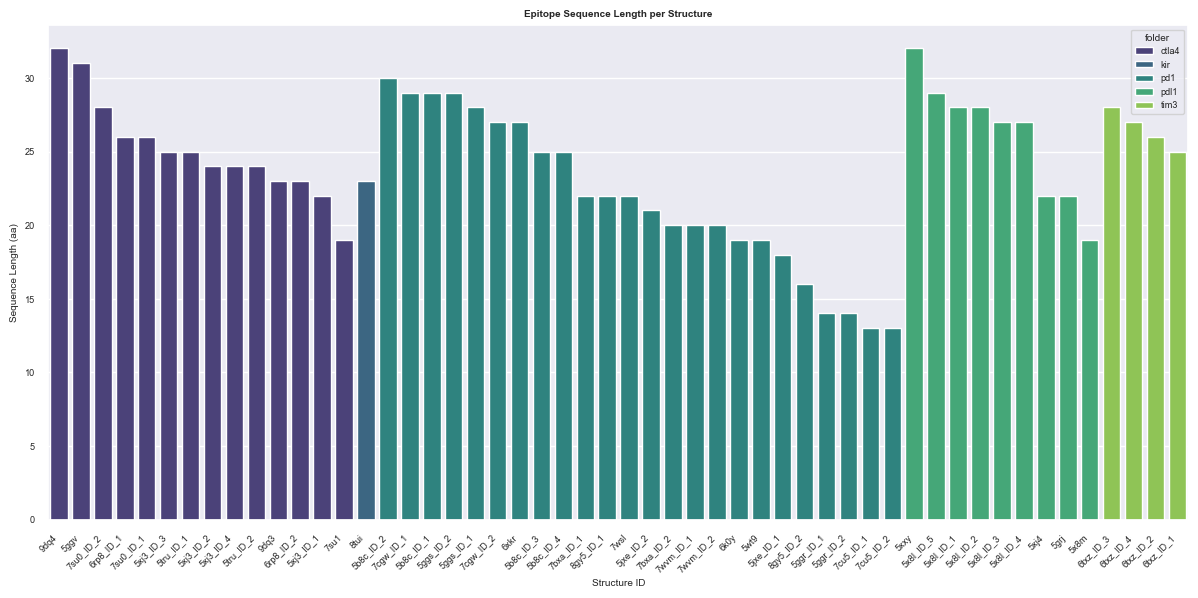

In [328]:
# Add column with sequence length
df_seq[f"{section}_length"] = df_seq[f"{section}_sequence"].str.len()

# Sort 
df_seq_sorted_by_length = df_seq.sort_values(by=["folder", f"{section}_length"], ascending=[True, False])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_seq_sorted_by_length, x="structure_id", y=f"{section}_length", hue="folder", dodge=False, palette="viridis")

plt.title(f"{section.capitalize()} Sequence Length per Structure")
plt.xlabel("Structure ID")
plt.ylabel("Sequence Length (aa)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_sequence_lengths.pdf", bbox_inches='tight')
plt.show()


In [329]:
import pandas as pd
from collections import defaultdict, Counter

# 1. Load data
df_struct = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_surface_hbonds_salt_bridges_summary.csv")

# 2. Create structure_id in df_struct
id_frequencies = Counter(df_struct["pdb_id"])
id_tracker = defaultdict(int)
structure_ids = []
for pdb_id in df_struct["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}ID{id_tracker[pdb_id]}")
df_struct["structure_id"] = structure_ids

# 3. Optional: remove duplicates from df_norm if needed
df_norm = df_norm.drop_duplicates(subset="pdb_id")

# 4. Merge everything
all_df = pd.merge(df_struct, df_sorted_seq[["structure_id", f"{section}_sequence"]], on="structure_id", how="left")
all_df = pd.merge(all_df, df_norm[["pdb_id", "binding_score"]], on="pdb_id", how="left")

# 5. Save
all_df.to_csv(f"data/structural_analysis/{section.capitalize()}/structural_{section}_all_information_final.csv", index=False)

In [330]:
all_df.rename(columns={"folder": "checkpoint"}, inplace=True)
print(all_df)

   pdb_id H_chain L_chain antigen_chain  epitope_area  num_hydrogen_bonds  \
0    5b8c       E       D             F   1769.807129                  27   
1    5xj3       D       E             F   1529.390869                  20   
2    5jxe       G       F             A   1245.531616                  19   
3    8gy5       H       L             P   1210.948486                  19   
4    5x8l       J       O             E   1705.828735                  29   
5    5b8c       B       A             C   1872.029907                  32   
6    5xj3       A       B             C   1485.807251                  16   
7    7su0       I       M             D   1668.169678                  16   
8    5ggv       H       L             Y   2085.559814                  40   
9    5ggr       H       L             Z   1006.088806                  31   
10   5x8l       G       L             B   1699.881348                  26   
11   7bxa       H       L             P   1238.410400                  24   

## Do cluster have different binding affinities? 

In [331]:
if section.lower() == "paratope":
    manual_clusters = {
    "Cluster 1": ["5x8m", "5xj4", "9dq3", "9dq4", "7su1", "7su0", "5xj3", "6rp8", "5tru" ],
    "Cluster 2": ["6txz"],
    "Cluster 3": ["5xB1", "5xxy"],
    "Cluster 4": ["5ggs", "5jxe", "5b8c"],
    "Cluster 5": ["7wvm", "8gy5"],
    "Cluster 6": ["7cgw", "7bxa"],
    "Cluster 7": ["5wt9", "5ggr"]
    }
else: 
    manual_clusters = {
    "Cluster 1": ["7su1", "5ggv", "9dq3", "6rp8", "5tru", "7su0", "6rp8", "5xq3"],
    "Cluster 2": ["5b8c", "5ggs", "5jxe", "7bxa", "6xkr", "7cgw", "5ggr", "5wt9", "7cu5", "8gy5", "7wsl", "6k0y", "7wym"],
    "Cluster 3": ["6txz"],
    "Cluster 4": ["5xxy", "5x8i", "5grj", "5xj4", "5x8m"],
}

# Convert manual Cluster-Dict in list 
cluster_rows = []
for cluster_name, pdb_list in manual_clusters.items():
    for pdb in pdb_list:
        cluster_rows.append({"pdb_id": pdb, "cluster": cluster_name})

# DF
cluster_df = pd.DataFrame(cluster_rows)

# 3. Merge with main df 
merged_df = cluster_df.merge(all_df[["pdb_id", "binding_score", "checkpoint"]], on="pdb_id", how="left")

print(merged_df)

   pdb_id    cluster  binding_score checkpoint
0    7su1  Cluster 1       0.341447      ctla4
1    5ggv  Cluster 1       0.376486      ctla4
2    9dq3  Cluster 1       0.404239      ctla4
3    6rp8  Cluster 1       0.113497      ctla4
4    6rp8  Cluster 1       0.113497      ctla4
5    5tru  Cluster 1       0.123491      ctla4
6    5tru  Cluster 1       0.123491      ctla4
7    7su0  Cluster 1       0.276012      ctla4
8    7su0  Cluster 1       0.276012      ctla4
9    6rp8  Cluster 1       0.113497      ctla4
10   6rp8  Cluster 1       0.113497      ctla4
11   5xq3  Cluster 1            NaN        NaN
12   5b8c  Cluster 2       0.177156        pd1
13   5b8c  Cluster 2       0.177156        pd1
14   5b8c  Cluster 2       0.177156        pd1
15   5b8c  Cluster 2       0.177156        pd1
16   5ggs  Cluster 2       0.330068        pd1
17   5ggs  Cluster 2       0.330068        pd1
18   5jxe  Cluster 2       0.093955        pd1
19   5jxe  Cluster 2       0.093955        pd1
20   7bxa  Cl

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/3831050858.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")


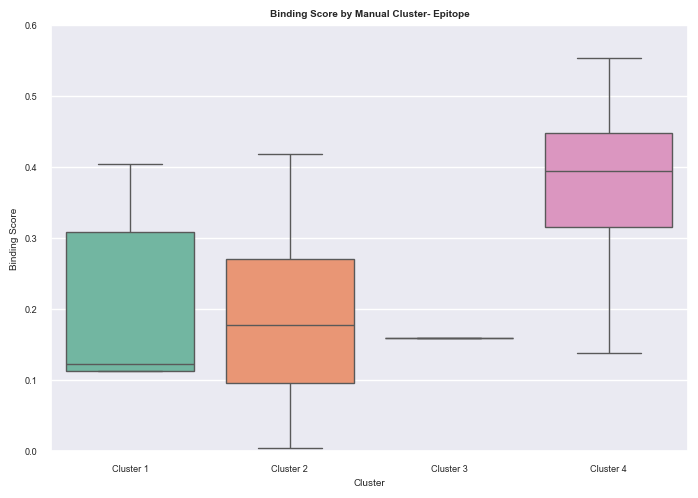

In [332]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")

plt.title(f"Binding Score by Manual Cluster- {section.capitalize()}")
plt.xlabel("Cluster")
plt.ylabel("Binding Score")
plt.tight_layout()
plt.ylim(0, 0.6)

plt.savefig(f"plots/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_binding_score_by_cluster.pdf", bbox_inches='tight')


In [333]:
# group by cluster 
grouped_scores = [
    group["binding_score"].dropna().values
    for name, group in merged_df.groupby("cluster")
]

# Kruskal–Wallis-Test
stat, p = kruskal(*grouped_scores)

print(f"Kruskal–Wallis-Test: H = {stat:.3f}, p = {p:.4e}")


Kruskal–Wallis-Test: H = 4.013, p = 2.6006e-01


/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


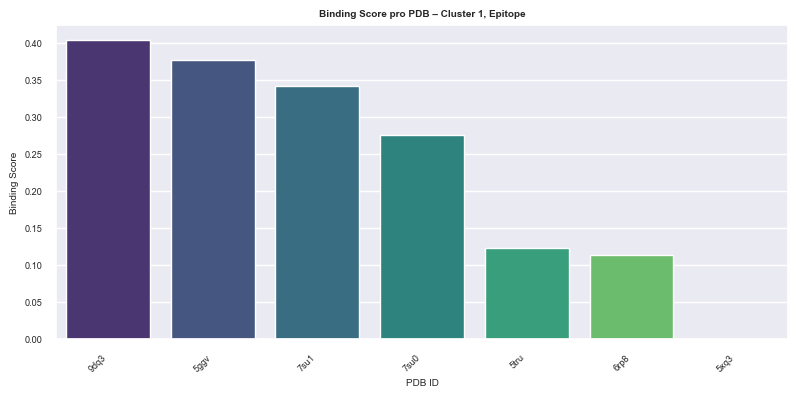

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


<Figure size 640x480 with 0 Axes>

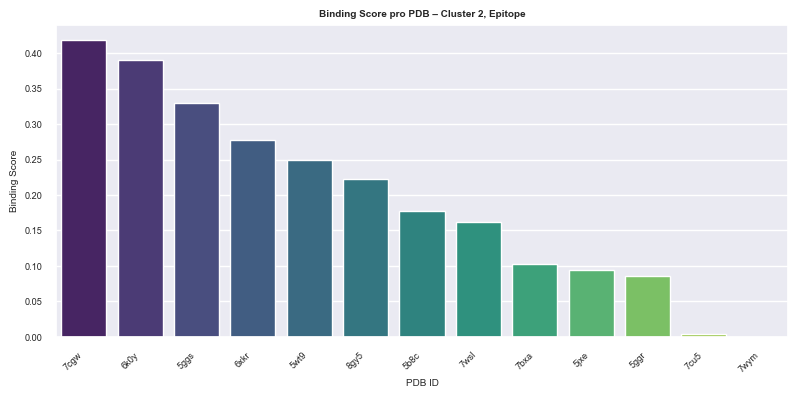

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


<Figure size 640x480 with 0 Axes>

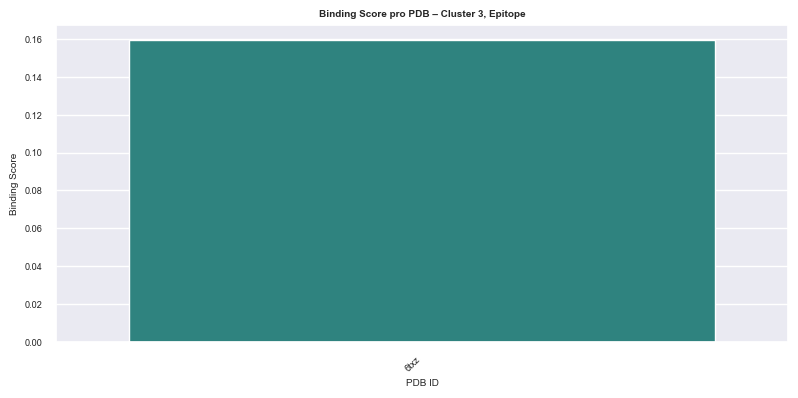

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


<Figure size 640x480 with 0 Axes>

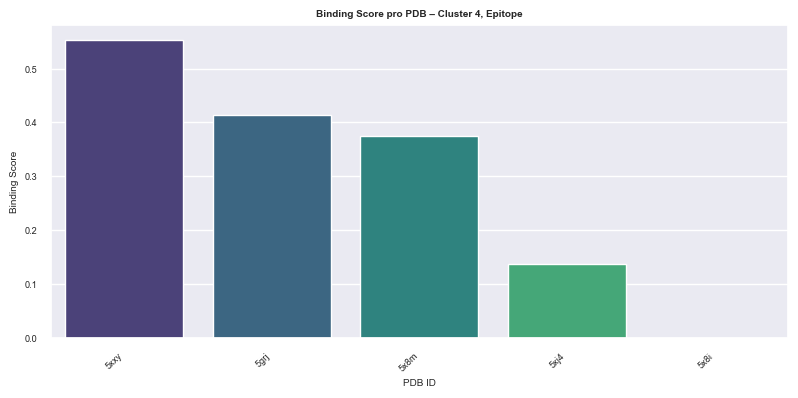

<Figure size 640x480 with 0 Axes>

In [334]:
clusters = merged_df["cluster"].unique()

# Plot per Cluster
for cluster_name in clusters:
    subset = merged_df[merged_df["cluster"] == cluster_name].sort_values("binding_score", ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
    plt.title(f"Binding Score pro PDB – {cluster_name}, {section.capitalize()}")
    plt.xlabel("PDB ID")
    plt.ylabel("Binding Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"plots/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_Binding Score pro PDB – {cluster_name}.pdf", bbox_inches='tight')



/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/2630072359.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])


Mann–Whitney U-Statistik: 68728.00
P-Wert: 0.9972


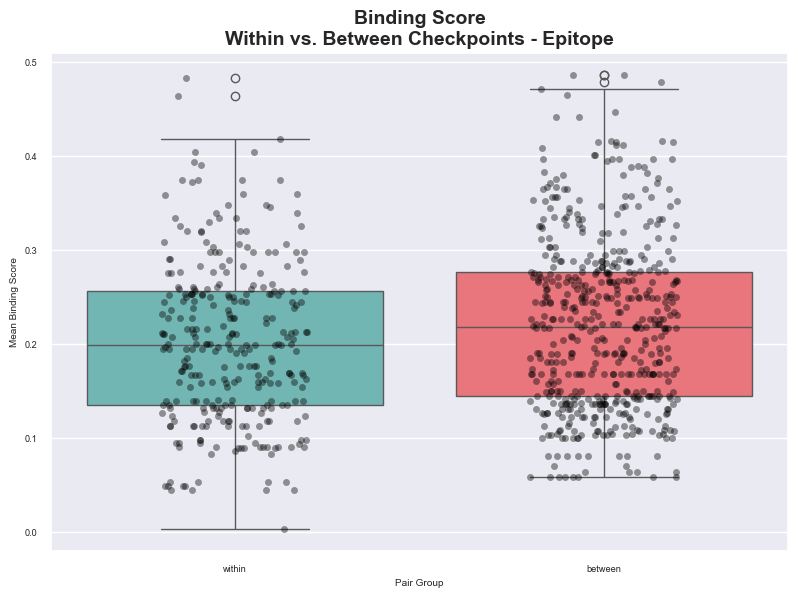

In [335]:
# Drop NaNs in binding_score or checkpoint 
clean_df = merged_df.dropna(subset=["binding_score", "checkpoint"])

# Generate all pairwise combinations
pairs = []
for (p1, row1), (p2, row2) in combinations(clean_df.iterrows(), 2):
    score1 = row1["binding_score"]
    score2 = row2["binding_score"]

    if pd.notna(score1) and pd.notna(score2):
        pairs.append({
            "pdb_1": row1["pdb_id"],
            "pdb_2": row2["pdb_id"],
            "mean_binding": (score1 + score2) / 2,
            "same_checkpoint": row1["checkpoint"] == row2["checkpoint"]
        })

# Create DataFrame and group labels
df_binding_pairs = pd.DataFrame(pairs)
df_binding_pairs = df_binding_pairs.dropna(subset=["mean_binding"])
df_binding_pairs["group"] = df_binding_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Statistical test
within = df_binding_pairs[df_binding_pairs["group"] == "within"]["mean_binding"]
between = df_binding_pairs[df_binding_pairs["group"] == "between"]["mean_binding"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_binding_pairs, x="group", y="mean_binding", color='black', alpha=0.4, jitter=0.2)

plt.title(f"Binding Score\nWithin vs. Between Checkpoints - {section.capitalize()}", fontsize=14)
plt.ylabel("Mean Binding Score")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [336]:
df_identity.index = df_identity.index.str.lower()
df_identity.columns = df_identity.columns.str.lower()
merged_df["pdb_id"] = merged_df["pdb_id"].str.lower()
print(df_identity)

                    ctla-4 | 6rp8_id_1  ctla-4 | 9dq3  ctla-4 | 6rp8_id_2  \
ctla-4 | 6rp8_id_1              100.00          84.62               88.46   
ctla-4 | 9dq3                    84.62         100.00               91.30   
ctla-4 | 6rp8_id_2               88.46          91.30              100.00   
ctla-4 | 5xj3_id_1               76.92          78.26               82.61   
ctla-4 | 5xj3_id_2               84.62          79.17               87.50   
ctla-4 | 5xj3_id_3               88.46          80.00               84.00   
ctla-4 | 5ggv                    70.97          70.97               67.74   
ctla-4 | 5xj3_id_4               80.77          79.17               83.33   
ctla-4 | 9dq4                    56.25          53.12               50.00   
ctla-4 | 7su0_id_1               96.15          84.62               84.62   
ctla-4 | 7su0_id_2               89.29          78.57               82.14   
ctla-4 | 5tru_id_1               88.46          80.00               88.00   

In [337]:
pairs = []

# Extrahiere nur die echten PDB-IDs aus dem df_identity-Index
# Annahme: Format ist "checkpoint | pdb_id"
df_identity.index = df_identity.index.str.extract(r"\|\s*(.*)")[0]
df_identity.columns = df_identity.columns.str.extract(r"\|\s*(.*)")[0]

# Iteriere über alle PDB-Paare
for pdb1, pdb2 in combinations(df_identity.index, 2):
    if pdb1 not in merged_df["pdb_id"].values or pdb2 not in merged_df["pdb_id"].values:
        continue  # Wenn einer fehlt, skip
    
    identity = df_identity.loc[pdb1, pdb2]
    
    # Hole die Checkpoints
    cp1 = merged_df[merged_df["pdb_id"] == pdb1]["checkpoint"]
    cp2 = merged_df[merged_df["pdb_id"] == pdb2]["checkpoint"]
    
    if cp1.empty or cp2.empty:
        continue
    
    group1 = cp1.values[0]
    group2 = cp2.values[0]
    same_group = group1 == group2

    pairs.append({
        "pdb1": pdb1,
        "pdb2": pdb2,
        "identity": identity,
        "same_checkpoint": same_group
    })

# Speichern in DataFrame
df_pairs = pd.DataFrame(pairs)

In [338]:
from scipy.stats import mannwhitneyu

within = df_pairs[df_pairs["same_checkpoint"] == True]["identity"]
between = df_pairs[df_pairs["same_checkpoint"] == False]["identity"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")


Mann–Whitney U-Statistik: 600.00
P-Wert: 0.0000


/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_1184/981194170.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])


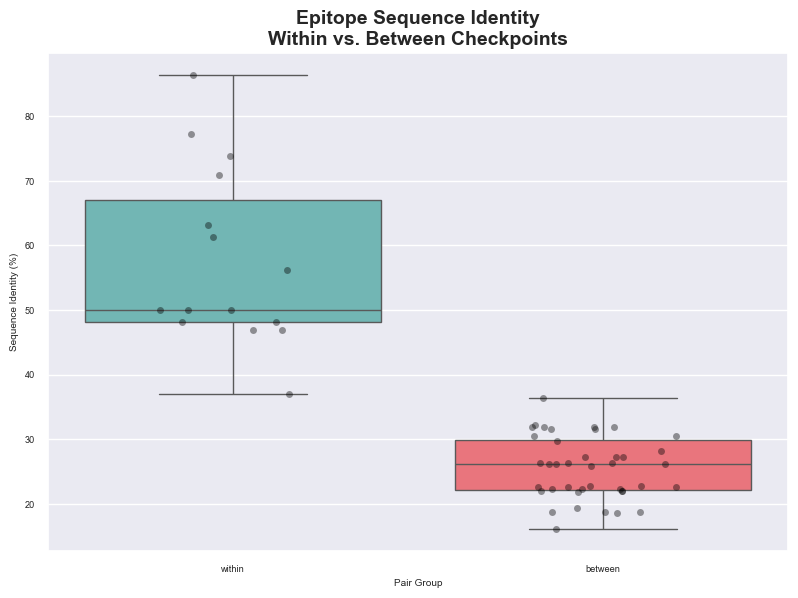

In [339]:
# Falls noch nicht vorhanden: 'same_checkpoint' als bool-Typ sichern
df_pairs["same_checkpoint"] = df_pairs["same_checkpoint"].astype(bool)

# Ersetze True/False durch beschreibende Labels
df_pairs["group"] = df_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_pairs, x="group", y="identity", color='black', alpha=0.4, jitter=0.2)
plt.title(f"{section.capitalize()} Sequence Identity\nWithin vs. Between Checkpoints", fontsize=14)
plt.ylabel("Sequence Identity (%)")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [340]:
wanted_best_pdbs = ['5xj4', '5x8m', '7bxa', '7cgw', '5b8c', '5ggs', '5jxe', '5x8l',
       '5xxy', '5wt9', '5ggr']

filtered_best_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

filtered_best_df.to_csv(f'data/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_filtered_pdbs_best.csv', index=False)

In [341]:
wanted_worst_pdbs = ['7wsl', '7wvm', '8gy5', '5grj', '6rp8', '5xj3', '9dq4', '7su0',
       '5tru', '7su1', '9dq3']

filtered_worst_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

filtered_worst_df.to_csv(f'data/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_filtered_pdbs_worst.csv', index=False)